# Домашнее задание
## Реализация алгоритма Deep Feature Interpolation

### План

1. Изучите алгоритм, описанный в [статье](https://arxiv.org/pdf/1611.05507.pdf).
2. Скачайте датасет (`faces.tar`) и разархивируйте его.
3. Реализуйте алгоритм **Deep Feature Interpolation**.
4. Продемонстрируйте результаты работы на произвольном изображении.

### Критерии оценки

* реализация базового алгоритма (с демонстрацией работы на каком-нибудь изображении из выборки): **50 баллов**
* визуализация интерполяции (варьировать степень модификации изменением $\alpha$): **30 баллов**
* применить алгоритм к какой-нибудь картике не из выборки (с применением детектора и вставкой обратно): **20 баллов**

### Подсказки

* для экономии памяти предлагается хранить в индексе не сами вектора, а их проекции на меньшее пространство (например, в качестве базиса использовать top-256 PCA, посчитанный на 5К-10К объектах выборки), а когда нужно посчитать вектор-смещение, просто пересчитывать необходимое количество
* поэкспериментируйте со взвешиванием основного лосса и полной вариации
* экспериментируйте на изображениях меньшего разрешения (например, 64х64)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content

/content


In [0]:
!tar -xf "/content/drive/My Drive/tt/MIPT Lecture 2019 03 28(1).zip (Unzipped Files)/MIPT Lecture 2019 03 28/data/faces.tar"

In [4]:
!ls /content/faces

gt.csv	images


In [0]:
from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_SIZE = 128

### Загрузка данных

*Предоставляемый датасет был размечен классификатором, поэтому может содержать большое количество ошибок. Тем не менее, для выполнения данного задания это не так критично.*

In [6]:
def load_dataset(directory):
    header = []
    labels = []
    filepaths = []
    
    with open(os.path.join(directory, 'gt.csv')) as f:
        header = f.readline().strip().split()[1:]
        header = [h.lower() for h in header]
        for line in f:
            fields = line.strip().split()
            path = os.path.join(directory, fields[0])
            filepaths.append(path)
            labels.append(fields[1:])

    return (
        header,
        np.array(labels),
        np.array(filepaths)
    )

DATASET_DIRECTORY_PATH = './faces'  
header, labels, filepaths = load_dataset(DATASET_DIRECTORY_PATH)

print(f"{len(filepaths)} изображений в датасете")

202278 изображений в датасете


In [7]:
print("Содержимое датасета по категориям:")
for i in range(len(header)):
    print(header[i], ":")
    names, counts = np.unique(labels[:, i], return_counts=True)
    for j in range(len(names)):
        print(" * ", names[j], ":", counts[j])

Содержимое датасета по категориям:
race :
 *  asian : 16215
 *  caucasian : 186063
gender :
 *  female : 134736
 *  male : 67542
age :
 *  adult : 75318
 *  old : 62429
 *  senior : 43973
 *  young : 20558
facial_hair :
 *  beard : 6689
 *  mustache : 2541
 *  shaved : 193048


In [8]:
# функция для удобного взаимодействия с разметкой

def get_mask(**kwargs):
    mask = np.ones(len(filepaths), dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels[:, header.index(h)], kwargs[h])
        else:
            mask &= labels[:, header.index(h)] == kwargs[h]
    return mask

def load_image(path, size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = Image.open(path)
    img = img.convert("RGB")
    img = img.resize(size, Image.BICUBIC)
    return img

# примеры запросов
print("count(asian & female) =", get_mask(race='asian', gender='female').sum())
print("count(caucasian & male & shaved) =", get_mask(race='caucasian', gender='male', facial_hair='shaved').sum())

count(asian & female) = 11046
count(caucasian & male & shaved) = 53359


### Функция $\phi(x)$

Определим функцию отображения в признаковое пространство в виде `nn.Module`:


In [9]:
class Phi(nn.Module):
    def __init__(self, pretrained=True):
        super(Phi, self).__init__()

        model = torchvision.models.vgg19(pretrained=pretrained)
        model = model.cuda()
        layers = list(model.features)
        self.slice_0 = nn.Sequential(*layers[0:12])
        self.slice_1 = nn.Sequential(*layers[12:21])
        self.slice_2 = nn.Sequential(*layers[21:30])

        for param in self.parameters():
            param.requires_grad = True

    def forward(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x = (x - mean) / std
        
        xs = []

        x = self.slice_0(x)
        x1 = x.view(x.shape[0], -1)
        
        x = self.slice_1(x)
        x2 = x.view(x.shape[0], -1)
        
        x = self.slice_2(x)
        x3 = x.view(x.shape[0], -1)
        
        return torch.cat((x1,x2,x3), 1)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
to_tensor = torchvision.transforms.ToTensor()
to_image = torchvision.transforms.ToPILImage()

phi = Phi().eval().cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:21, 27205579.65it/s]


number of features per image:  425984


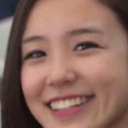

In [10]:
# пример использования


image = load_image(filepaths[101])
fx = phi(to_tensor(image).unsqueeze(0).cuda())[0]

print("number of features per image: ", fx.shape[0])
image

### Построение индекса базы

Извлеките признаки (функцией $\phi$) из изображений базы. По этим признакам вы будете искать похожие изображения, поэтому можно хранить их сжатое представление.

In [11]:
from sklearn.decomposition import PCA
import tqdm
pca = PCA(n_components=256)

compressed = []
for i in tqdm.tqdm(range(0, 1000)):
    image = load_image(filepaths[i])
    fx = phi(to_tensor(image).cuda().unsqueeze(0)).cpu().detach().numpy()[0]
    compressed.append(fx)

pca.fit(compressed)


100%|██████████| 1000/1000 [00:05<00:00, 174.48it/s]


PCA(copy=True, iterated_power='auto', n_components=256, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
compressed = []

#batch = []
#for filepath in tqdm.tqdm(filepaths): #tqdm.tqdm(
#  image = load_image(filepath)
#  fx = phi(to_tensor(image).cuda().unsqueeze(0))[0]
#  batch.append(fx)
#  if len(batch) == 64:
#    compressed.extend(pca.transform(batch))
#    batch = []

#compressed.extend(pca.transform(batch))

In [0]:
#np.save("/content/drive/My Drive/tt/MIPT Lecture 2019 03 28(1).zip (Unzipped Files)/MIPT Lecture 2019 03 28/compressed.npy",
#       np.array(compressed))

In [0]:
compressed = np.load("/content/drive/My Drive/tt/MIPT Lecture 2019 03 28(1).zip (Unzipped Files)/MIPT Lecture 2019 03 28/compressed.npy")

### Функция подбора кандидатов

У нас есть база признаков, по которым мы можем искать изображения, похожие на запрос. Напишите функцию, которая для данного изображения `query` находит `n` наиболее похожих на него (по сжатому признаковому описанию) среди изображений, покрываемых бинарной маской `mask` (размер маски равен количеству изображений в базе). В качестве меры похожести можете использовать косинусную меру.

In [0]:
from scipy.spatial.distance import cosine

#compressed = np.array(compressed)
def best_similar(query_image, mask, n=10):
    distance = []
    for i in range(0, 202278):
        if mask[i]==True:
            distance.append(cosine(query_image, compressed[i]))
        else:
            distance.append(100500)
    #print(compressed[np.argsort(np.array(distance))[:n]])
    w = np.argsort(np.array(distance))[:100]
    plt.figure(figsize=(15,15))
    for num, i in enumerate(w):
        plt.subplot(10,10,num+1)
        plt.imshow(load_image(filepaths[i]))
    plt.show()
    return np.array([(phi(to_tensor(np.array(load_image(filepaths[i]))).unsqueeze(0).cuda()).cpu().detach().numpy()[0]) for i in np.argsort(np.array(distance))[:n]])

### Вычисление центров кластеров

Используя функцию `best_similar` реализуйте функцию подсчёта центров кластеров в признаковом пространстве $\phi$ изображений, наиболее похожих на изображение-запрос. С использованием этой функции вы сможете для двух различных наборов атрибутов (например `caucasian & male` и `asian & male`) вычислить вектор-смещение, по которому мы будем "двигать" признаковое описание оптимизируемого изображения. 

*Заметьте, что если мы будем производить модификацию из `caucasian & male` в `asian & male`, то изображение, которое мы оптимизируем, должно принадлежать множеству `caucasian & male`, иначе результат может получиться так себе.*

In [0]:
query_image = compressed[101]
image = load_image(filepaths[101])

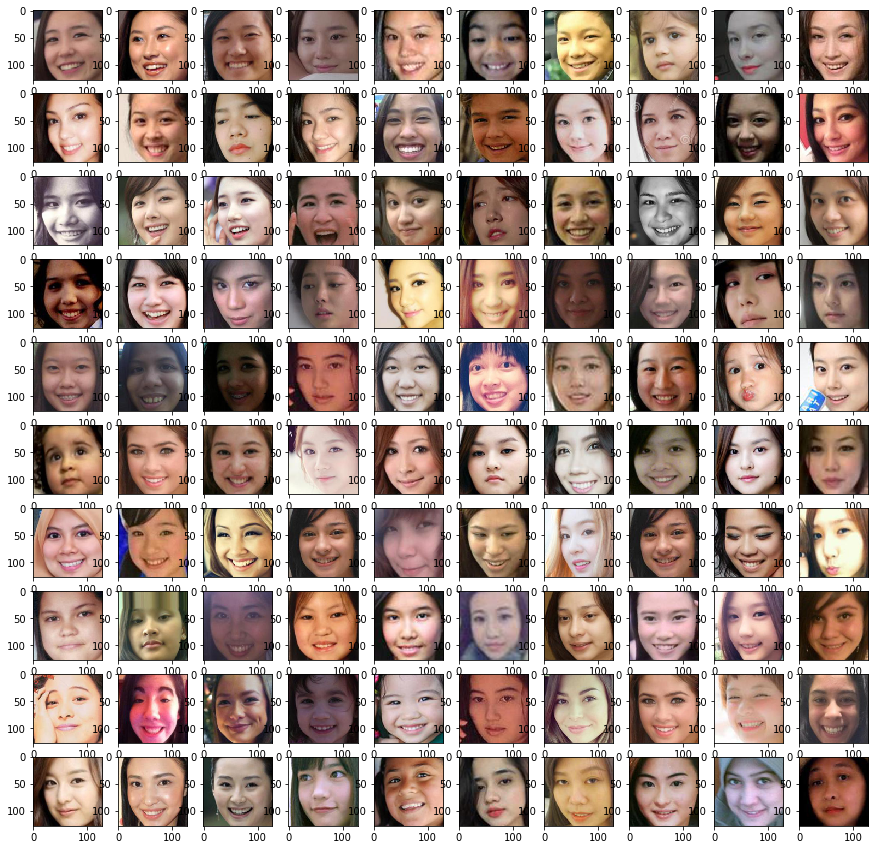

(425984,)


In [0]:

mask1 = get_mask(race='asian', gender='female', facial_hair='shaved', age='young')
center1 = np.mean(best_similar(query_image, mask1), axis=0)
print(center1.shape)

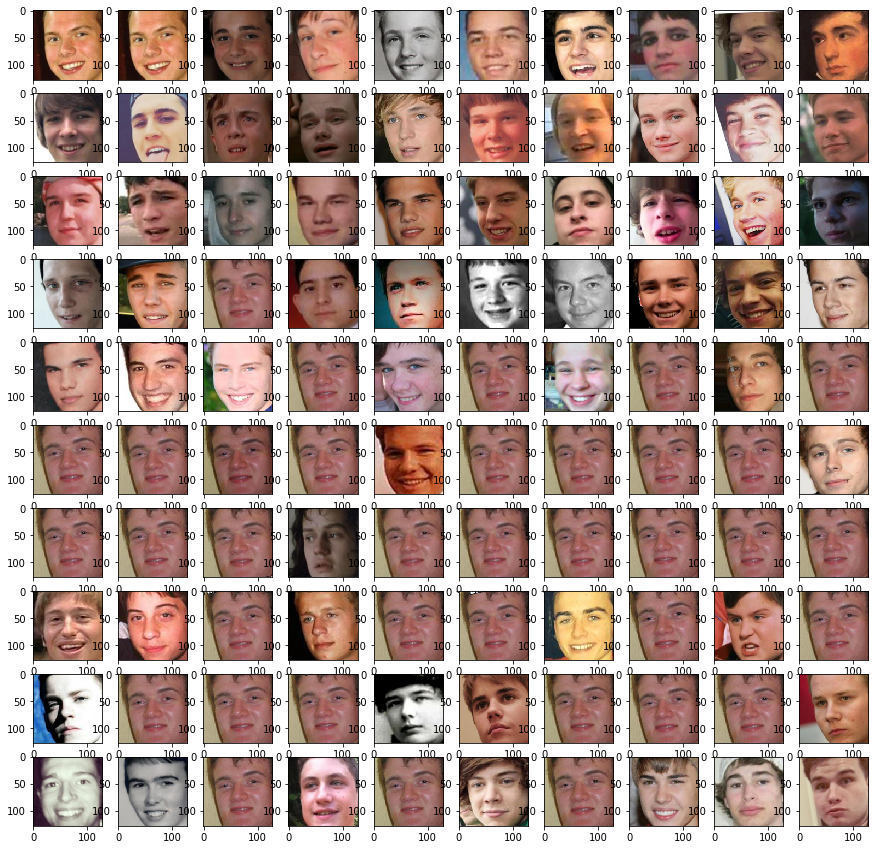

(425984,)


In [0]:
mask2 = get_mask(race='caucasian', gender='male', facial_hair='shaved', age='young')
center2 = np.mean(best_similar(query_image, mask2), axis=0)
print(center2.shape)

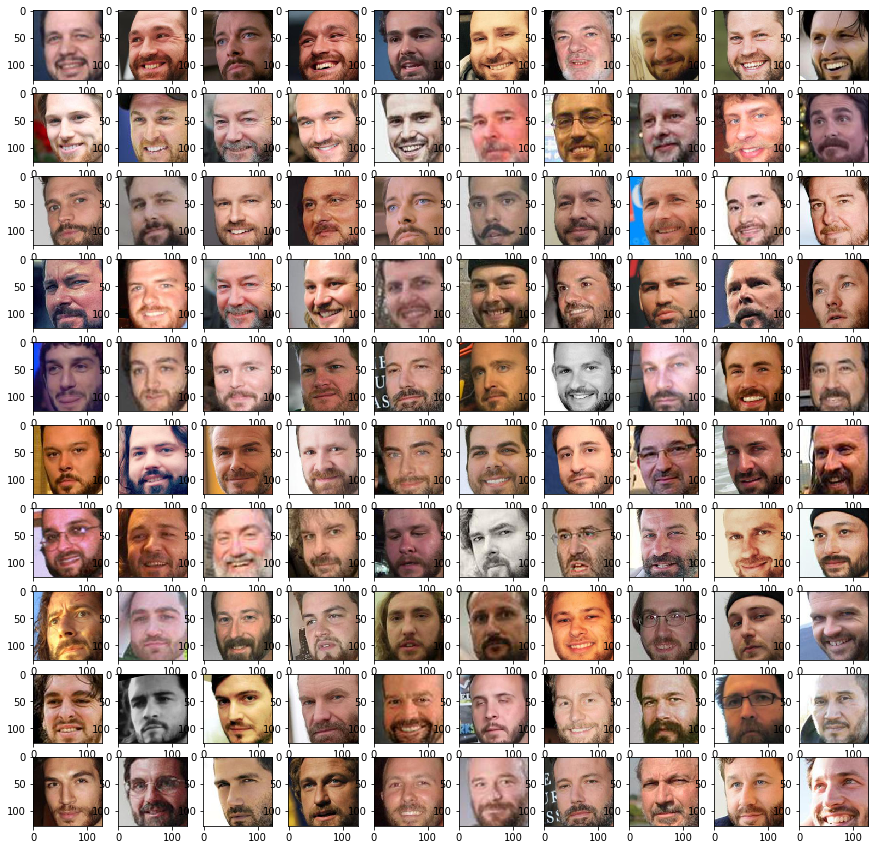

(425984,)


In [0]:

mask3 = get_mask(race='caucasian', gender='male', facial_hair='beard')
center3 = np.mean(best_similar(query_image, mask3), axis=0)
print(center3.shape)

### Функция потерь

Реализуйте функцию потерь, которую мы будем минимизировать для выбранного изображения и вычисленного для него вектора смещения.

In [0]:
def dfi_loss(input, phi_input, phi_input_shifted, alpha=1e2):
  
    du = input[:, :, :-1, :-1] - input[:, :, 1:, :-1]
    dv = input[:, :, :-1, :-1] - input[:, :, :-1, 1:]
    tv = torch.mean(du*du+dv*dv).cuda()
    mse = torch.mean(torch.pow(phi_input - phi_input_shifted,2))

    return mse + tv*alpha

### Оптимизиация

Напишите код оптимизиации изображения с использованием какого-нибудь оптимизатора.

In [0]:
import torch.optim as optim
import tqdm
def dfi(image, center2, alpha=1e2, writer=None):
    # создадим копию изображения, которую будем оптимизировать
    image = image.requires_grad_()
    lr = 10e-3
    # положим её в оптимизиатор (подойдёт, в приницпе, любой)
    optimizer = optim.Adam([image], lr=lr)

    for i in range(2000):
        # предсказываем logits 
        # (если применить softmax, то получим вероятности)
        output = phi(image.unsqueeze(0).cuda())[0]
        #print(1)
        # обнуляем градиенты
        optimizer.zero_grad()
        
        # считаем то, что хотим минимизировать
        loss = dfi_loss(image.unsqueeze(0), 
                        output, center2, alpha)
        #print(loss)
        
        # вычисляем градиенты
        loss.backward()
        
        # шаг оптимизации
        optimizer.step()
        if i==1000:
            lr = lr/2
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        # клипаем изображение, так как значения
        # пикселей могли выйти за границы
        image.data.clamp_(0, 1)
    
    # возращаем оптимизированные изображение
    return image.detach().cpu()

Эксперимент с лоссом: меняется степень размытия

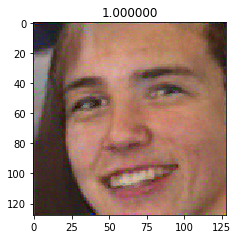

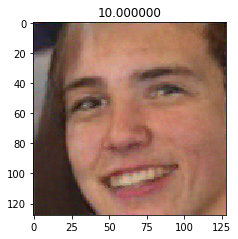

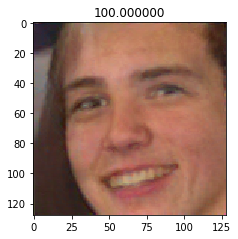

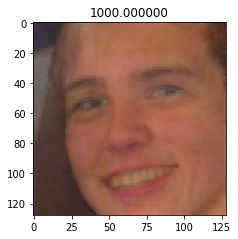

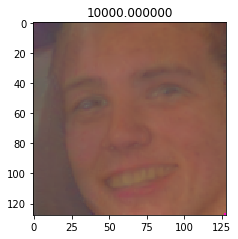

In [0]:
# ваш код + визуализация результата
import matplotlib.pyplot as plt
import datetime


image = load_image(filepaths[101])
phi_image = np.array(phi(to_tensor(image).unsqueeze(0).cuda()).cpu().detach()[0])

for i in range(0,5):
    image2 = dfi(to_tensor(image),
                                 torch.tensor(2.0*(center2 - center1) + phi_image).cuda(), alpha=10**i, writer=writer) 
    plt.figure(figsize=(20,5))
    plt.subplot(1,5,i+1)
    plt.imshow(np.moveaxis(image2.numpy(),0,2))
    plt.gca().set_title("%f"%10**i)
#plt.subplot(1,2,2)
#plt.imshow(np.moveaxis(image2.numpy(),0,2))
#plt.show()


### Устранение артефактов (желательно)

В результате оптимизации на изображении могут появиться нежелательные артeфакты в виде смещения цветовой палитры. Попробуйте побороть это вычитанием из результата разницы между исходным изображением и модифицированным изображением с параметром $\alpha=0$.

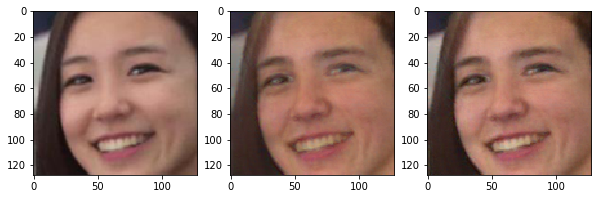

In [0]:
# ваш код + визуализация результата
import matplotlib.pyplot as plt


image = load_image(filepaths[101])
phi_image = np.array(phi(to_tensor(image).unsqueeze(0).cuda()).cpu().detach()[0])
image2 = dfi(to_tensor(image),
                             torch.tensor(1.5*(center2 - center1) + phi_image).cuda()) 

image0 = dfi(to_tensor(image),
                             torch.tensor(phi_image).cuda()) 

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(np.array(image))

plt.subplot(1,3,2)
plt.imshow(np.moveaxis(image2.numpy(), 0,2))

plt.subplot(1,3,3)
plt.imshow(np.moveaxis(image2.numpy(), 0,2) + (np.array(image)/256 - (np.moveaxis(image0.numpy(), 0,2))))
plt.show()

### Интерполяция в признаковом пространстве (бонус)

Постройте последовательность изображений с варьированием степени модификации.

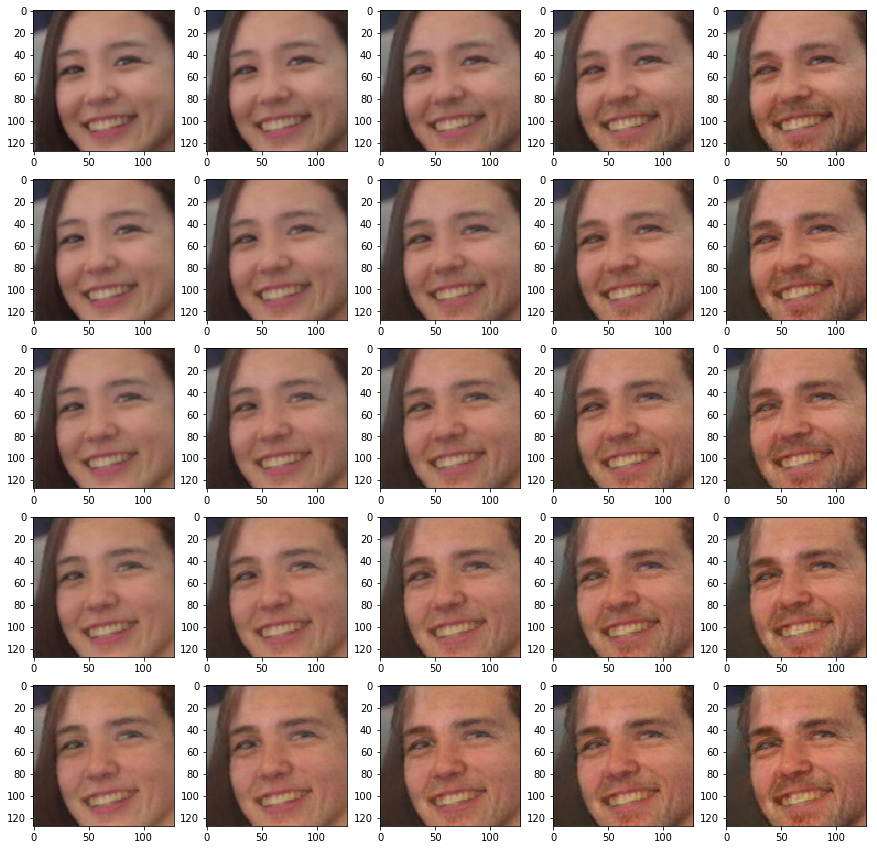

In [0]:
# ваш код + визуализация результата

image = load_image(filepaths[101])
phi_image = np.array(phi(to_tensor(image).unsqueeze(0).cuda()).cpu().detach()[0])
plt.figure(figsize=(15,15))
d = 5
for j,i in enumerate(np.linspace(0,1.5,d)):
    for k,l in enumerate(np.linspace(0,1.5,d)):
        plt.subplot(d, d, j*d+k+1)
        image2 = dfi(to_tensor(image),
                             torch.tensor(i*(center2 - center1) + l*(center3 - center1) + phi_image).cuda()) 
    plt.imshow(np.moveaxis(image2.numpy(),0,2))
plt.show()

In [0]:
# ваш код + визуализация результата

### Работа с изображениями не из базы (бонус)

Ниже приведена функция `get_face_bbox`, которая возращает координаты для кропа лица из изображения. Используйте её, чтобы вырезать изображение лица, произвести над ним какую-нибудь трансформацию (например, смена пола или расы), а затем вставить модифицированное изображение обратно.

In [0]:
import cv2


HAAR_CASCADE_FILEPATH = '/content/drive/My Drive/tt/MIPT Lecture 2019 03 28(1).zip (Unzipped Files)/MIPT Lecture 2019 03 28/data/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILEPATH)

def get_face_bbox(image):
    faces = cascade.detectMultiScale(
        np.asarray(image),
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(50, 50),
        flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) != 1:
        return None
    x, y, w, h = faces[0]
    return x, y, x + w, y + h

In [0]:
# ваш код + визуализация результата

filepath = '/content/drive/My Drive/tt/MIPT Lecture 2019 03 28(1).zip (Unzipped Files)/MIPT Lecture 2019 03 28/data/leo.jpg'

106   93   318   305


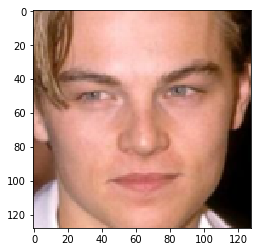

In [16]:
image = Image.open(filepath).convert("RGB")

x1,y1,x2,y2 = get_face_bbox(image)
print(x1, ' ', y1, ' ', x2, ' ', y2)

image1 = image.crop((x1,y1, x2,y2))
image1 = image1.resize((128, 128), Image.BICUBIC)
plt.imshow(image1)
plt.show()

(1, 256)
(256,)


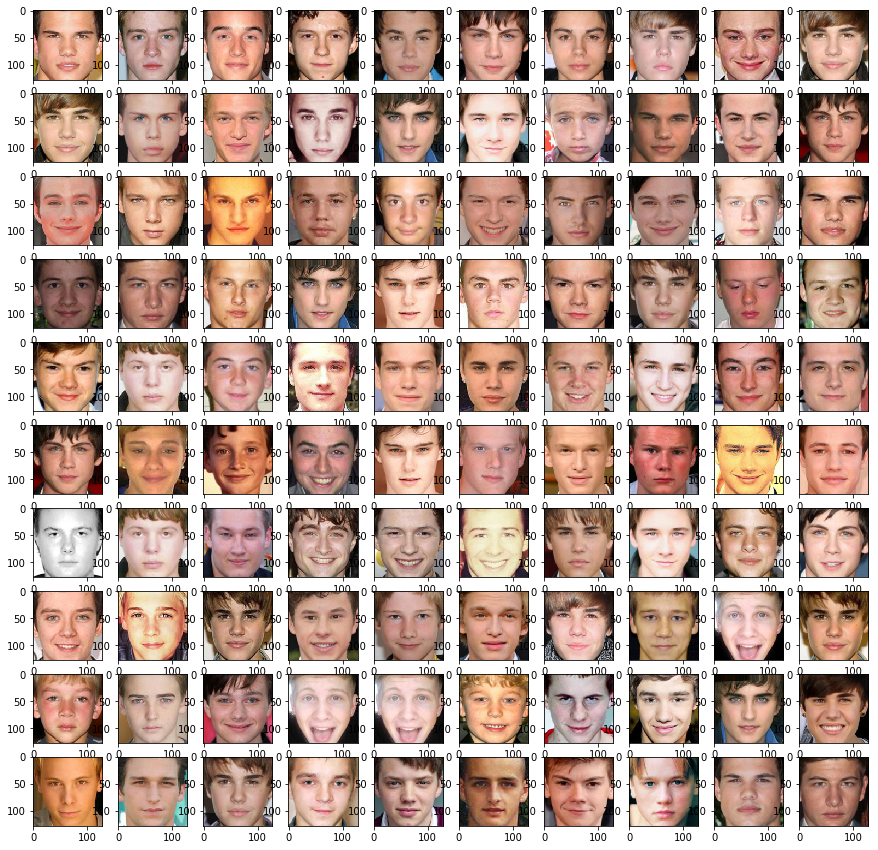

(425984,)


In [17]:
image_phi = pca.transform([phi(to_tensor(image1).cuda().unsqueeze(0)).cpu().detach().numpy()[0]])
print(image_phi.shape)
print(compressed[0].shape)
mask1 = get_mask(race='caucasian', gender='male', facial_hair='shaved', age='young')
center1 = np.mean(best_similar(image_phi, mask1), axis=0)
print(center1.shape)

(1, 256)
(256,)


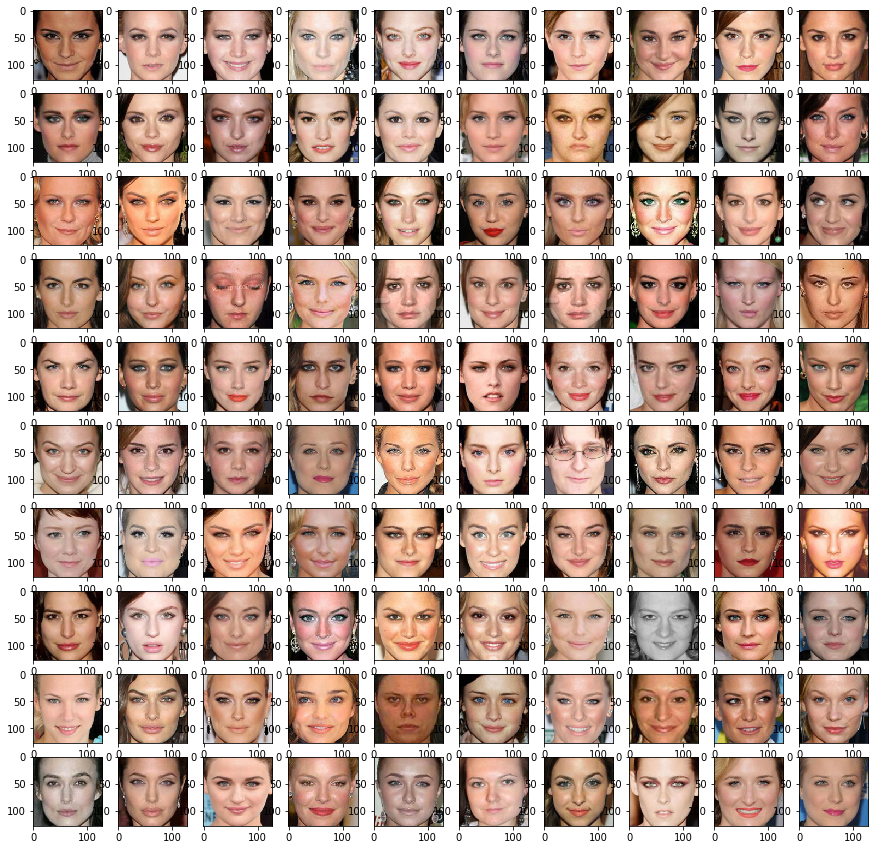

(425984,)


In [18]:
image_phi = pca.transform([phi(to_tensor(image1).cuda().unsqueeze(0)).cpu().detach().numpy()[0]])
print(image_phi.shape)
print(compressed[0].shape)
mask2 = get_mask(race='caucasian', gender='female', facial_hair='shaved', age='adult')
center2 = np.mean(best_similar(image_phi, mask2), axis=0)
print(center2.shape)

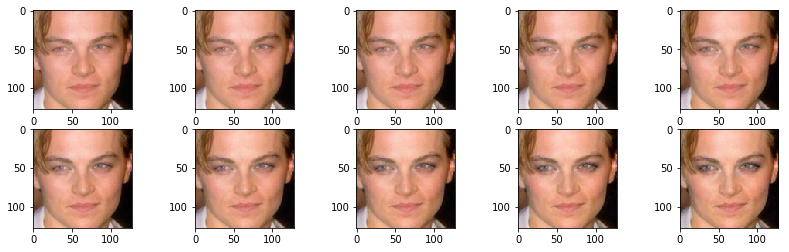

In [23]:
import matplotlib.pyplot as plt

image_phi = np.array(phi(to_tensor(image1).unsqueeze(0).cuda()).cpu().detach()[0])

plt.figure(figsize=(14,4))
for j,i in enumerate(np.linspace(0,1.5,10)):
    plt.subplot(2,5, j+1)
    image2 = dfi(to_tensor(image1),
                             torch.tensor(i*(center2 - center1) + image_phi).cuda()) 
    plt.imshow(np.moveaxis(image2.numpy(),0,2))
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


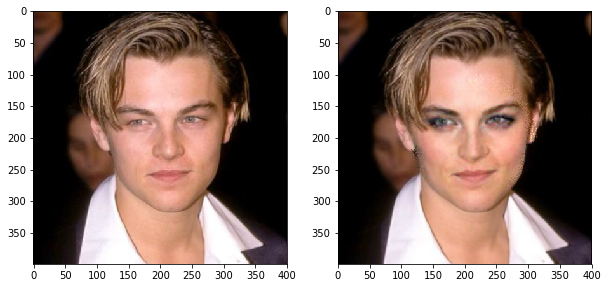

In [128]:
from scipy.ndimage.interpolation import zoom


def contrast_loss(input):
    du = input[:, :, :-1, :-1] - input[:, :, 1:, :-1]
    dv = input[:, :, :-1, :-1] - input[:, :, :-1, 1:]
    tv = torch.mean(du*du+dv*dv).cuda()
    return tv

def smoothing(image):
    image = image.requires_grad_()
    lr = 10e-3
    optimizer = optim.Adam([image], lr=lr)

    for i in range(2):
        optimizer.zero_grad()
        loss = contrast_loss(image.unsqueeze(0))
        loss.backward()
        optimizer.step()
        image.data.clamp_(0, 1)
    return image.detach().cpu()

import torchvision.transforms.functional as F
image2 = F.to_pil_image((dfi(to_tensor(image1),
                             torch.tensor(2*(center2 - center1) + image_phi).cuda()) + \
                         (to_tensor(image1) - dfi(to_tensor(image1),torch.tensor(image_phi).cuda()))).data.clamp_(0, 1))


image2 = image2.resize((x2-x1, y2-y1), Image.BICUBIC)


image_n = image.copy()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)

image_n = image.copy()

# маска: круг с размытыми краями
# вставляем только лицо без фона
mask = np.zeros((x2-x1,y2-y1))
for i in range(0,x2-x1):
    for j in range(0,y2-y1):
        mask[i,j] = int((i*2 - (x2-x1))*(i*2 - (x2-x1)) + (j*2 - (y2-y1))*(j*2 - (y2-y1)) - np.random.randint(18000) < 25000)
mask = Image.fromarray(np.uint8(255*mask))
image_n.paste(image2, (x1,y1), mask)

# немного сглаживаем результаты вставки
image_n = smoothing(to_tensor(image_n))
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(image_n.numpy(), 0,2))
plt.show()




In [0]:
#!kill -9 -1